In [1]:
##Taken from Machine Learning for Algorithmic Trading 2nd Edition chapter 2, very little new code here, just used to practice/explore pd, binary transformation, and hdf file creation/use.

Info from textbook


| Message Type | Order Book Impact | Number of Messages |
|--------------|-----------------|------------------|
| A | New unattributed limit order | 136,522,761 |
| D | Order canceled | 133,811,007 |
| U | Order canceled and replaced | 21,941,015 |
| E | Full or partial execution; possibly multiple messages for the same original order | 6,687,379 |
| X | Modified after partial cancellation | 5,088,959 |
| F | Add attributed order | 2,718,602 |
| P | Trade Message (non-cross) | 1,120,861 |
| C | Executed in whole or in part at a price different from the initial display price | 157,442 |
| Q | Cross Trade Message | 17,233 |


| Name                   | Offset | Length | Value     | Notes                                                                              |
| ---------------------- | ------ | ------ | --------- | ---------------------------------------------------------------------------------- |
| Message Type           | 0      | 1      | S         | System Event Message                                                               |
| Stock Locate           | 1      | 2      | Integer   | Always 0                                                                           |
| Tracking Number        | 3      | 2      | Integer   | Nasdaq internal tracking number                                                    |
| Timestamp              | 5      | 6      | Integer   | Nanoseconds since midnight                                                         |
| Order Reference Number | 11     | 8      | Integer   | The unique reference number assigned to the new order at the time of receipt       |
| Buy/Sell Indicator     | 19     | 1      | Alpha     | The type of order being added. B = Buy Order, S = Sell Order                       |
| Shares                 | 20     | 4      | Integer   | The total number of shares associated with the order being added to the book       |
| Stock                  | 24     | 8      | Alpha     | Stock symbol, right padded with spaces                                             |
| Price                  | 32     | 4      | Price (4) | The display price of the new order. Refer to Data Types for field processing notes |
| Attribution            | 36     | 4      | Alpha     | Nasdaq Market participant identifier associated with the entered order             |


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.chdir("C:/Users/jmeek/Desktop/quant!")
os.makedirs(r"C:\Users\jmeek\Desktop\quant!\Orderbook", exist_ok=True)


In [4]:
import matplotlib
import gzip
import shutil
import pandas
import matplotlib.pyplot
import seaborn
import openpyxl
import tables
from matplotlib.ticker import FuncFormatter
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from datetime import timedelta
from time import time
%matplotlib inline


In [5]:
seaborn.set_style('whitegrid')

In [6]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS based on a numeric time value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.2f}'

In [44]:
#Setting Data Path
data_path = Path("Orderbook")
itch_store = str(data_path/'itch.h5')
order_book_store = data_path/'order_book.h5'

In [8]:
HTTPS_URL = 'https://emi.nasdaq.com/ITCH/NASDAQ%20ITCH/'
SOURCE_FILE = '10302019.NASDAQ_ITCH50.gz'

In [9]:
#Assuming data is downloaded and unzipped 

In [10]:
event_codes = {'O': 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

In [11]:
encoding = {'primary_market_maker' : {'Y': 1, 'N': 0},
            'printable': {'Y': 1, 'N': 0},
            'buy_sell_indicator':{'B': 1, 'S': -1},
            'cross_type' : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction': {'B':0, 'S':1, 'N':0, 'O':-1}}


In [12]:
formats = {
    ('integer', 2): 'H', 
    ('integer', 4): 'I',
    ('integer', 6): '6s', 
    ('integer', 8): 'Q',
    ('alpha',   1): 's',
    ('alpha',   2): '2s',
    ('alpha',   4): '4s',
    ('alpha',   8): '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

In [13]:
message_data = (pandas.read_excel('message_types.xlsx', sheet_name='messages')
                           .sort_values('id')
                           .drop('id', axis=1))

In [14]:
message_data.head()

,Name,Offset,Length,Value,Notes
0,Message Type,0,1,S,System Event Message
1,Stock Locate,1,2,Integer,Always 0
2,Tracking Number,3,2,Integer,Nasdaq internal tracking number
3,Timestamp,5,6,Integer,Nanoseconds since midnight
4,Event Code,11,1,Alpha,See System Event Codes below


In [15]:
#string cleaning
def clean_message_types(df):
    df.columns = [c.lower().strip() for c in df.columns]
    df.value = df.value.str.strip()
    df.name= (df.name
                .str.strip()
                .str.lower()
                .str.replace(' ', '_')
                .str.replace('-', '_')
                .str.replace('/','_'))
    df.notes = df.notes.str.strip()
    df['message_type'] = df.loc[df.name == 'message_type', 'value']
    return df

In [16]:
message_types = clean_message_types(message_data)

In [17]:
#Extract message types and names
message_labels = (message_types.loc[:, ['message_type', 'notes']]
                  .dropna()
                  .rename(columns={'notes': 'name'}))
message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))
message_labels.head()

,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


In [18]:
message_types.message_type = message_types.message_type.ffill()
message_types = message_types[message_types.name !='message_type']
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', ' ')
                       .str.replace(')', ' '))
message_types.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152 entries, 1 to 172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          152 non-null    object
 1   offset        152 non-null    int64 
 2   length        152 non-null    int64 
 3   value         152 non-null    object
 4   notes         152 non-null    object
 5   message_type  152 non-null    object
dtypes: int64(2), object(4)
memory usage: 8.3+ KB


In [19]:
message_types.head()


,name,offset,length,value,notes,message_type
1,stock_locate,1,2,integer,Always 0,S
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S
3,timestamp,5,6,integer,Nanoseconds since midnight,S
4,event_code,11,1,alpha,See System Event Codes below,S
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


In [20]:
#creating tuples to capture mesage content
message_types.loc[:, 'formats'] = (message_types[['value', 'length']]
                                   .apply(tuple, axis=1).map(formats))

In [21]:
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

In [22]:
message_fields, fstring = {}, {}

for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())

    #remove non-strings
    formats_list = [f for f in message.formats.tolist() if isinstance(f, str)]
    fstring[t] = '>' + ''.join(formats_list)

print("All message type codes available:", sorted(fstring.keys()))


All message type codes available: ['A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'J', 'K', 'L', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y', 'h']


In [23]:
message_fields, fstring = {}, {}

#edit column names to match message_types.xlsx
message_types = message_types.rename(columns={
    'id': 'message_type', 
    'Name': 'name', 
    'Offset': 'offset', 
    'Length': 'length', 
    'value': 'value'  
})

def get_format(row):
    v = row['value'].lower()
    l = int(row['length'])
    if v == 'integer':
        return {2: 'H', 4: 'I', 6: '6s', 8: 'Q'}[l]
    elif v == 'alpha':
        return f"{l}s"
    elif 'price' in v:
        return {4: 'I', 8: 'Q'}[l]
    else:
        raise ValueError(f"Unknown type: {v}, length: {l}")

message_types['formats'] = message_types.apply(get_format, axis=1)

for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    formats_list = message.formats.tolist()
    
    if any(not isinstance(x, str) for x in formats_list):
        raise TypeError(f"Non-string format in message type {t}: {formats_list}")
    
    fstring[t] = '>' + ''.join(formats_list)

In [24]:
alpha_fields.info

<bound method DataFrame.info of                                  offset  length  value  \
name                                                     
event_code                           11       1  alpha   
stock                                11       8  alpha   
market_category                      19       1  alpha   
financial_status_indicator           20       1  alpha   
round_lots_only                      25       1  alpha   
issue_classification                 26       1  alpha   
issue_sub_type                       27       2  alpha   
authenticity                         29       1  alpha   
short_sale_threshold_indicator       30       1  alpha   
ipo_flag                             31       1  alpha   
luld_reference_price_tier            32       1  alpha   
etp_flag                             33       1  alpha   
inverse_indicator                    38       1  alpha   
stock                                11       8  alpha   
trading_state                        19 

In [25]:
alpha_fields.head()

,offset,length,value,notes,message_type,formats
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s


In [26]:
#post-processing from format_alpha
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""

    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

In [27]:
def store_messages_safe(m):
    """Handle occasional storing of all messages"""
    with pandas.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            data = pandas.DataFrame(data) 
            try:
                data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
                data.timestamp = pandas.to_timedelta(data.timestamp)
            except Exception as e:
                print(f"Timestamp conversion error for {mtype}: {e}")
                continue
            if mtype in alpha_formats:
                for col in data.columns:
                    if col in alpha_formats[mtype]:
                        data[col] = data[col].apply(
                            lambda x: x.decode("utf-8").strip() 
                            if isinstance(x, bytes) else str(x).strip()
                        )

            #some of the following varies from the textbook since message_types.xlsx was updated and column retrieval had to be updated
            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c) for c in data.columns if c in s}
            
            dc = ['stock_locate']
            string_cols = data.select_dtypes(include='object').columns.tolist()
            if 'stock' in string_cols:
                dc.append('stock')
            elif mtype == 'R':
                dc.append('stock')
                
            object_cols = data.select_dtypes(include='object').columns
            if len(object_cols) > 0:
                for col in object_cols:
                    data[col] = data[col].astype(str)

            try:
                store.append(
                    mtype,
                    data,
                    format='t',
                    min_itemsize=s if s else None, 
                    data_columns=dc
                )
            except Exception as e:
                print(f"HDF5 store error for {mtype}: {e}")
                print(data.info())
                data.to_csv(f'data_error_{mtype}.csv', index=False)
                return 1

    return 0


In [28]:
messages = defaultdict(list)
message_count = 0
message_type_counter = Counter()

In [29]:
print(sorted(message_fields.keys()))
message_types[message_types.message_type == 'S']


['A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'J', 'K', 'L', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y', 'h']


,name,offset,length,value,notes,message_type,formats
1,stock_locate,1,2,integer,Always 0,S,H
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S,H
3,timestamp,5,6,integer,Nanoseconds since midnight,S,6s
4,event_code,11,1,alpha,See System Event Codes below,S,1s


In [30]:
messages = defaultdict(list)

start = time()
message_count = 0

with open('10302019.NASDAQ_ITCH50', 'rb') as data:
    while True:
        size_bytes = data.read(2)
        if not size_bytes:
            break

        message_size = int.from_bytes(size_bytes, byteorder='big', signed=False)

        type_byte = data.read(1)
        if not type_byte:
            break

        message_type = type_byte.decode('ascii')

        if message_size <= 1:
            continue

        record = data.read(message_size - 1)

        try:
            message = message_fields[message_type]._make(
                unpack(fstring[message_type], record)
            )
            messages[message_type].append(message)
        except Exception as e:
            print(e)
            print(message_type)
            print(record)
            print(fstring.get(message_type))
            continue

        message_count += 1

        if message_type == 'S':
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            d = format_time(time() - start)
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')

            if message.event_code.decode('ascii') == 'C':
                res = store_messages_safe(messages) 
                if res == 1:
                    print(pandas.Series(dict(message_type_counter)).sort_values())
                    break
                messages.clear() 

        if message_count % int(2.5e7) == 0:
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            d = format_time(time() - start)
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')

            res = store_messages_safe(messages) 
            if res == 1:
                print(pandas.Series(dict(message_type_counter)).sort_values())
                break

            messages.clear()

print('Duration:', format_time(time() - start))



 Start of Messages
	03:02:31.65	           1	00:00:0.00

 Start of System Hours
	04:00:0.00	     241,259	00:00:1.04

 Start of Market Hours
	09:30:0.00	   9,559,280	00:00:34.50
	09:44:9.23	  25,000,000	00:01:23.63
	10:07:45.15	  50,000,000	00:04:52.97
	10:39:56.24	  75,000,000	00:08:6.42
	11:18:9.64	 100,000,000	00:11:17.72
	11:58:35.35	 125,000,000	00:14:31.47
	12:44:20.61	 150,000,000	00:17:48.30
	13:41:3.75	 175,000,000	00:20:59.58
	14:18:44.52	 200,000,000	00:24:13.85
	14:49:19.38	 225,000,000	00:27:25.38
	15:19:40.72	 250,000,000	00:30:38.87
	15:50:23.01	 275,000,000	00:33:51.78

 End of Market Hours
	16:00:0.00	 290,920,165	00:36:38.71

 End of System Hours
	20:00:0.00	 293,944,864	00:36:45.54

 End of Messages
	20:05:0.00	 293,989,079	00:36:45.63
Duration: 00:38:24.76


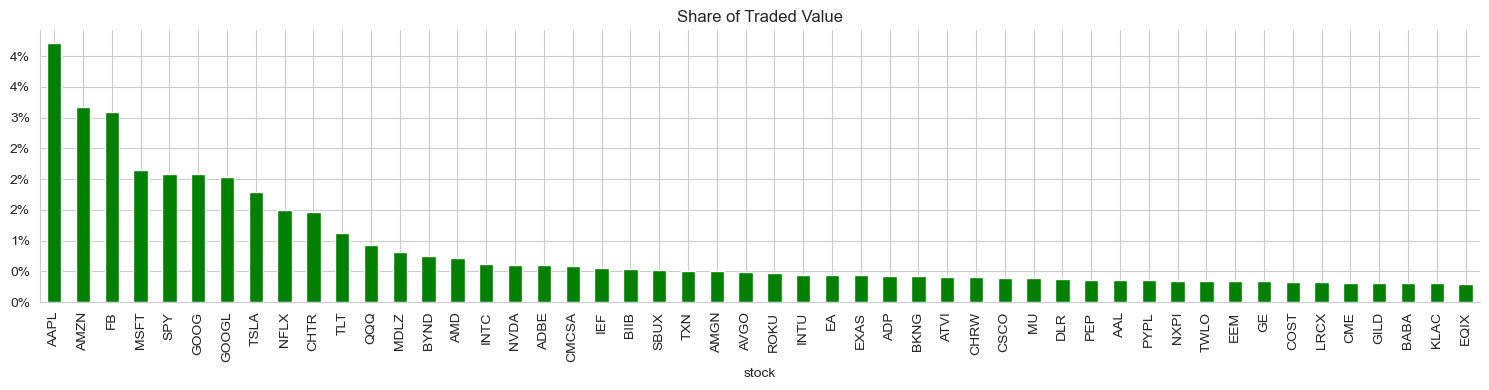

In [45]:
with pandas.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = pd.concat(
        [
            store['P'],
            store['Q'].rename(columns={'cross_price': 'price'})
        ],
        ignore_index=True
    ).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

trade_summary = (
    trades.groupby('stock')
    .value_share.sum()
    .sort_values(ascending=False)
)

trade_summary.iloc[:50].plot.bar(
    figsize=(15, 4),
    color='green',
    title='Share of Traded Value'
)

matplotlib.pyplot.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
seaborn.despine()
matplotlib.pyplot.tight_layout()
